#**Step 01: Clone the Github Repo**

In [1]:
!git clone https://github.com/facebookresearch/segment-anything.git

Cloning into 'segment-anything'...
remote: Enumerating objects: 295, done.
remote: Total 295 (delta 0), reused 0 (delta 0), pack-reused 295
Receiving objects: 100% (295/295), 18.31 MiB | 32.95 MiB/s, done.
Resolving deltas: 100% (156/156), done.


#**Step 02: Setting the Current Directory**

In [2]:
%cd /content/segment-anything

/content/segment-anything


#**Step 03: Install All the Dependencies**

In [3]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/segment-anything
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything


#**Step 04: Download the pre-trained model**

In [4]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-06-14 17:21:40--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.162.120, 108.157.162.108, 108.157.162.83, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.162.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  97.6MB/s    in 23s     

2023-06-14 17:22:03 (106 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



#**Step 05: Import All the Required Libraries**

In [5]:
import torch
import torchvision
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [6]:
import torch
torch.cuda.empty_cache()

In [7]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

#**Step 06: Checking if the GPU is Available**

In [8]:
print("CUDA is available:", torch.cuda.is_available())

CUDA is available: True


#**Step 07: Download a Sample Image and Read it**

In [9]:
!gdown "https://drive.google.com/uc?id=1_o3nhUN8vZ9WT8s8Ji3i3cIo4Dx6UBlt&confirm=t"


Downloading...
From: https://drive.google.com/uc?id=1_o3nhUN8vZ9WT8s8Ji3i3cIo4Dx6UBlt&confirm=t
To: /content/segment-anything/image1.jpg
100% 4.72M/4.72M [00:00<00:00, 20.5MB/s]


In [10]:
!gdown "https://drive.google.com/uc?id=1I3RF-QGaLewJZ5y-DIK4B9epbgkHu02r&confirm=t"


Downloading...
From: https://drive.google.com/uc?id=1I3RF-QGaLewJZ5y-DIK4B9epbgkHu02r&confirm=t
To: /content/segment-anything/download.jfif
100% 7.13k/7.13k [00:00<00:00, 25.2MB/s]


In [11]:
!gdown "https://drive.google.com/uc?id=16R9N5m4HcBhs1MVmwGjwcn8ffnZoB7n5&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=16R9N5m4HcBhs1MVmwGjwcn8ffnZoB7n5&confirm=t
To: /content/segment-anything/car.jfif
100% 6.17k/6.17k [00:00<00:00, 25.9MB/s]


In [12]:
!gdown "https://drive.google.com/uc?id=1AD5sMyrjUDBqAOX1H_D4R9iVnlR9wF78&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1AD5sMyrjUDBqAOX1H_D4R9iVnlR9wF78&confirm=t
To: /content/segment-anything/newimage.jfif
100% 13.8k/13.8k [00:00<00:00, 40.7MB/s]


#**Step 08: Reading the Sample Image**

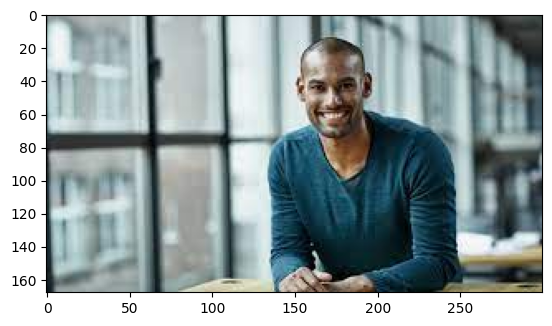

In [13]:
image = cv2.imread('download.jfif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

#**Step 09: Loading the Model Checkpoints to Device**

In [14]:
# Model_checkpoint
sam_checkpoint = "sam_vit_h_4b8939.pth"
# Define the Model Type
model_type = "vit_h"
# Setting the Device as GPU
device = "cuda"
#It will take few seconds to load and push it to device
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [15]:
# Mask Generator is applied on the images to segment the images
#Segment Anything Model Automatic Mask Generator is imported from the SegmentAnything Library.
#Automatic Mask Generator Scans the image based on the points we provide

mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    #The lower the IOU threshold the more objects it is picking up if there is junk then increase the threshold
    #By Adjusting threshold we get fewer but more accurate objects
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)


In [16]:
# Applying the Mask Generator on the Image
masks = mask_generator_.generate(image)

print(len(masks))

29


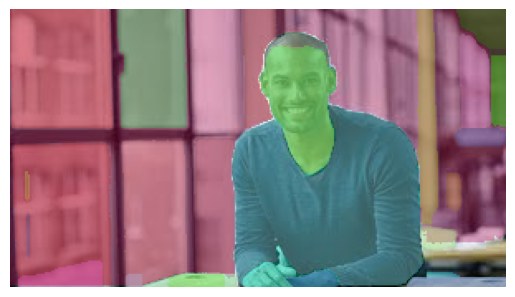

In [17]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

#**Segment Anything Model on Video**

#**Install the Package**

In [18]:
!pip install metaseg


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for metaseg: filename=metaseg-0.7.5-py3-none-any.whl size=45761 sha256=f3e65a1d27e729bae1749729df8e6fc0fa7dd9ff4902edfe2b67c7cb34d9f956
  Stored in directory: /root/.cache/pip/wheels/d6/c2/f1/39bf6715a28dd54b1e5e1fdc3d252e10124e1a974a92c09b13
Successfully built metaseg


#**Import All the Required Libraries**

In [19]:
from metaseg import SegAutoMaskPredictor


In [20]:
import torch
torch.cuda.empty_cache()

In [21]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   2518 MiB |   5738 MiB | 322926 MiB | 320408 MiB |\n|       from large pool |   2507 MiB |   5728 MiB | 322257 MiB | 319750 MiB |\n|       from small pool |     10 MiB |     15 MiB |    668 MiB |    658 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   2518 MiB |   5738 MiB | 322926 MiB | 320408 MiB |\n|       from large pool |   2507 MiB |   5728 MiB |

#**Download the  Demo Videos From Drive**

In [22]:
!gdown "https://drive.google.com/uc?id=171sWgcHuO-zdMp1cqyaspOJyCWYHnFBY&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=171sWgcHuO-zdMp1cqyaspOJyCWYHnFBY&confirm=t
To: /content/segment-anything/videonew.mp4
100% 451k/451k [00:00<00:00, 113MB/s]


In [23]:
!gdown "https://drive.google.com/uc?id=1Cj_h_t3nJ9WkKnlCZt5uKnPw77Go5F7-&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1Cj_h_t3nJ9WkKnlCZt5uKnPw77Go5F7-&confirm=t
To: /content/segment-anything/video2.mp4
100% 8.80M/8.80M [00:00<00:00, 71.1MB/s]


#**Implementing the Segment Anything on Video**

In [24]:
results = SegAutoMaskPredictor().video_predict(
    source="videonew.mp4",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16,
    points_per_batch=64,
    min_area=1000,
    output_path="output.mp4",
)


  0%|          | 0/106 [00:00<?, ?it/s]

vit_l model has been successfully downloaded and saved as 'vit_l.pth'.


100%|██████████| 106/106 [08:47<00:00,  4.98s/it]


#**Display the Output Video**

In [27]:
!rm "/content/result_compressed.mp4"

rm: cannot remove '/content/result_compressed.mp4': No such file or directory


In [28]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/segment-anything/output.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)